# importing libraries

In [2]:
import matplotlib.pyplot as plt #this is used to plot training losses and training accuraciesat the end 
from glob import glob #to create list of all the files present in a directory
import cv2 #to read and perform actions on the images
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator # ImageDataGenertor is to create a form of the data from datasets so that machine learning model can understand it
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential # "Model" is to define a tensorflow model and "Sequential" is a type of tensorflow model.
from tensorflow.keras.optimizers import Adam # "Adam" is a type of optimizer
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau # "ModelCheckpoint" is to store the each and every point of the iteration and "ReduceLROnPlateau" is a function where we decrease learning rate as there is no difference or little difference in the learning rate at the end o the training. 
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image # these are to import and display images
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

2024-07-04 18:25:59.541414: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 18:25:59.541519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 18:25:59.680824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version: 2.15.0


'''
"Dense" layer is like a linear function.
"Input" is function by which we decide size of inputs.
"Dropout" is used so that ML model does not work on the full dataset (columns can be dropped using it).
"Flatten" changes matrics into 1D array.
"Conv2D" is used to read images and learn features from it
"BatchNormalization" does normaization over the batch of data.
"Activation" is a function through which we change the values of a data so that it does not become only a linear model.
"MaxPooling2D" is filter where we changes the dimensions of the images so that as we increase convolutional layers, the data to be processed should not be increasing.
'''

# Exploring Dataset

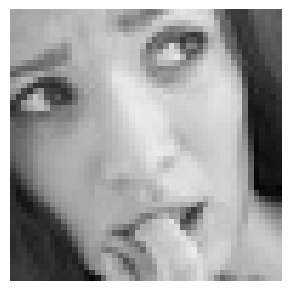

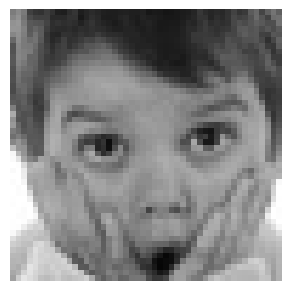

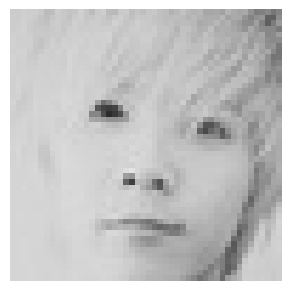

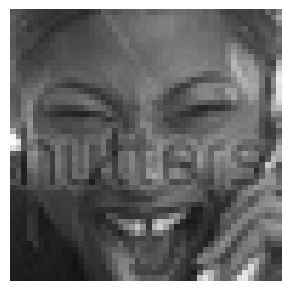

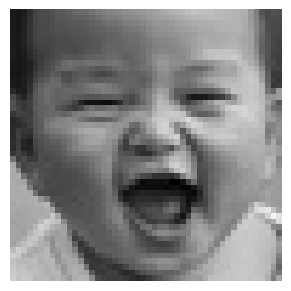

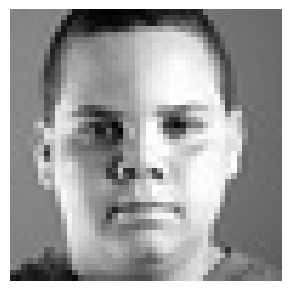

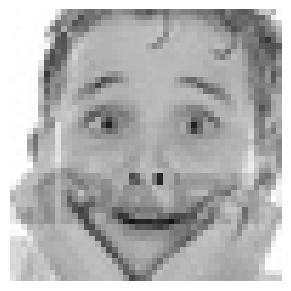

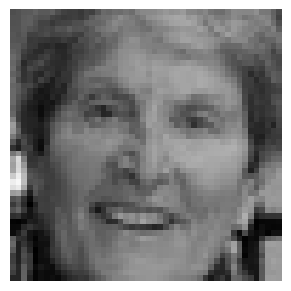

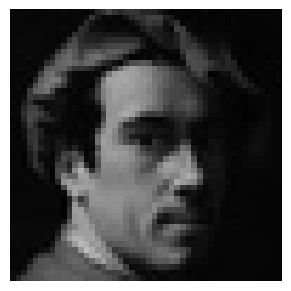

In [4]:
# Nullclass instructor's code
images = glob("/kaggle/input/fer2013/train/**/**")
for i in range(9):
    image=random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image))
    plt.axis('off')

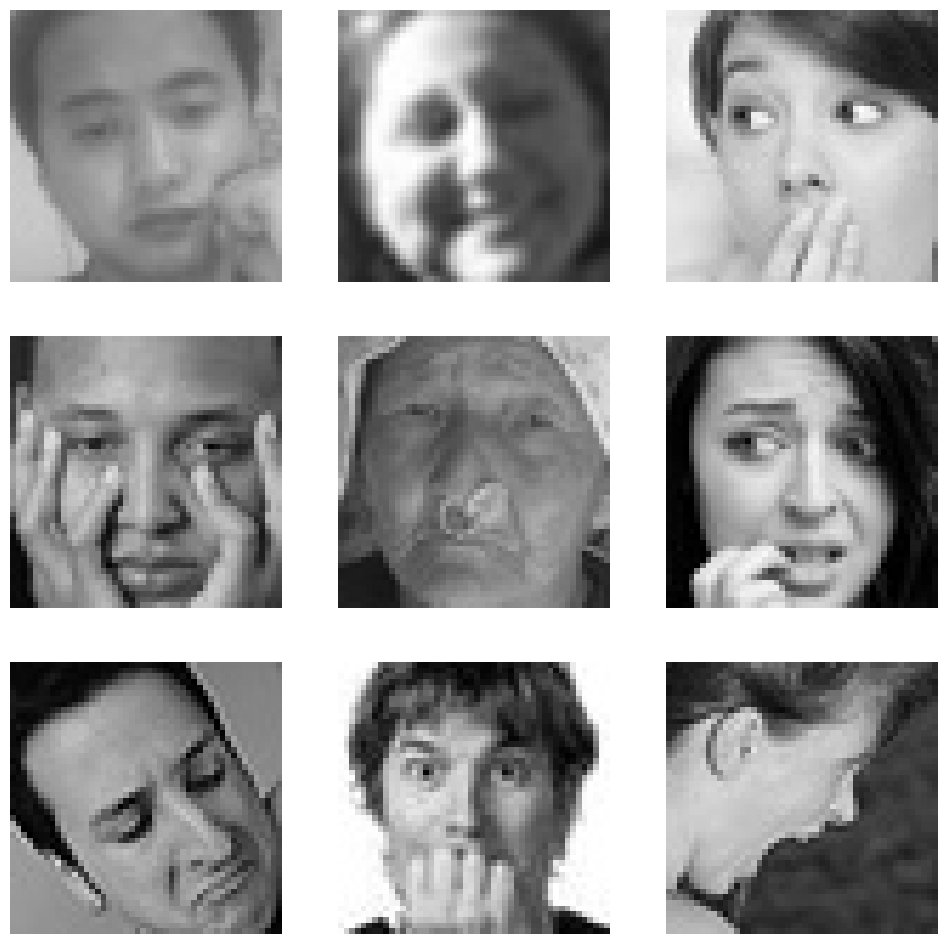

In [5]:
'''
#chatGPT code
import glob
import random
import cv2
import matplotlib.pyplot as plt

# Get the list of image paths
image_paths = glob.glob("/kaggle/input/fer2013/train/**/**", recursive=True)

# Plot 9 random images
plt.figure(figsize=(12, 12))
for i in range(9):
    image_path = random.choice(image_paths)
    image = cv2.imread(image_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis

plt.show()
'''


# Preparing Data for Training

In [24]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle = True)
datagen_validation= ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Defining Model

In [25]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    return x

In [26]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

In [28]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,64,(3,3))
    conv_2 = Convolution(conv_1,128,(5,5))
    conv_3 = Convolution(conv_2,512,(3,3))
    conv_4 = Convolution(conv_3,512,(3,3))

    flatten = Flatten()(conv_4)

    dense_1 = Dense_f(flatten,256)
    dense_2 = Dense_f(dense_1,512)

    output = Dense(7,activation = "softmax")(dense_2)
    model = Model(inputs = [inputs], outputs = [output])
    
    opt = Adam(learning_rate=0.0005)

    model.compile(loss = ['categorical_crossentropy'], optimizer = opt, metrics = ['accuracy'])

    return model

In [29]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     1,179,90

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

# **Initialising the model**

In [30]:
epochs = 15 # this should be a very large no. but since large epoch will take more time so for practice purpose we are taking it small.
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model.weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor= 'val_loss', factor=0.1, patience=2, min_lr=0.00001)
callbacks = [checkpoint,reduce_lr]

# **Training the Model**

In [33]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15
446/448 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5624 - loss: 1.1501
Epoch 1: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.5624 - loss: 1.1501 - val_accuracy: 0.5737 - val_loss: 1.1100 - learning_rate: 1.0000e-05
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5938 - loss: 1.0503
Epoch 2: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.5938 - loss: 1.0503 - val_accuracy: 0.6000 - val_loss: 1.2068 - learning_rate: 1.0000e-05
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5737 - loss: 1.1250
Epoch 3: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.5737 - loss: 1.1250 - val_accuracy: 0.5826 - val_loss: 1.0997 - learning_rate: 1.0000e-05
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5781 - loss: 1.2778
Epoch 4: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step 

**Model Evaluation**

In [34]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.5842 - loss: 1.0943


[1.089501142501831, 0.5869323015213013]

**Plotting Loss**

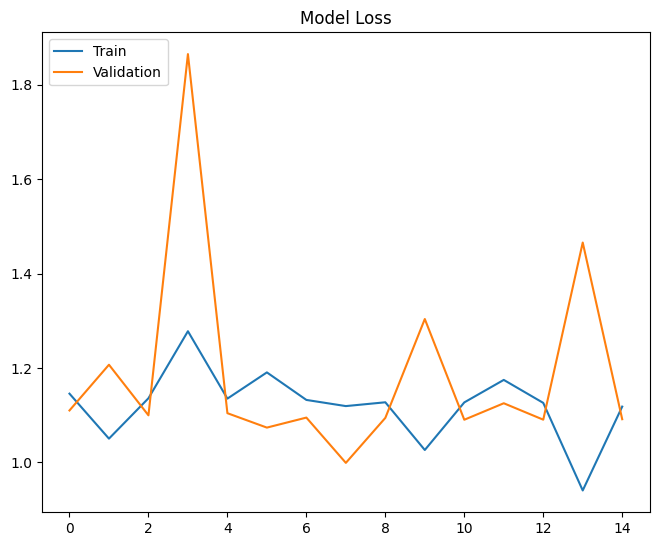

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

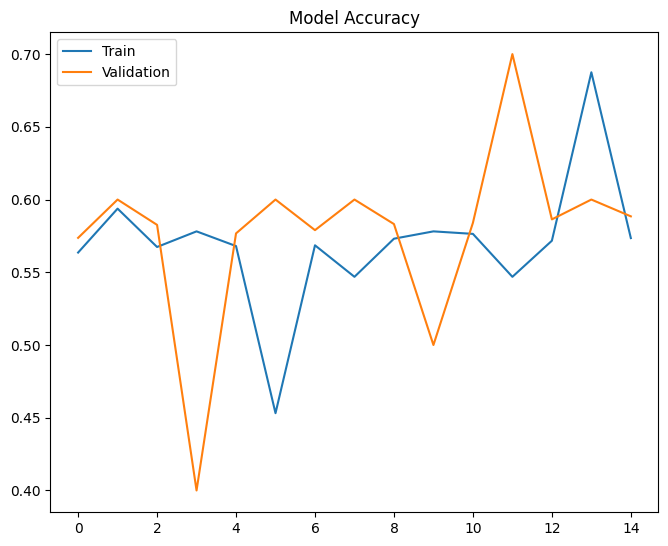

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

**Saving Model Architect**

In [44]:
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)